# Kickstarter Project Success Prediction

#### Background: 
I have been interested in crowdfunding and the opportunities it creates for people to start their businesses. Kickstarter is one of the largest platforms on the web that allows entrepreneurs to share their ideas with many potential investors. Although, thousands of projects get listed, a large proportion of them fail to become successful. I wanted to see what factors contribute to this outcome.

#### Problem: 
Can we predict the success of the project on [Kickstarter](https://www.kickstarter.com/) given widely accessible project characteristics?

#### Data Sources:
The data have been scraped by the [Webroots](https://webrobots.io/kickstarter-datasets/) for the date of 2018-02-15. Relevant columns include:
- backers_count - the number of investors currently supporting the project
- category - the category/subcategory a specific project falls under
- country - the country from which the project originated
- location - the city from which the project originated
- goal - the amount of funding a project needs to achieve
- usd_pledged - the amount of funding currently received
- launched_at - the date on which the project started the crowdfunding campaign
- deadline - the date by which the project has to reach its goal
- staff_pick - the status which indicates whether the project gained interest from Kickstarter staff
- disable_communication - the status which indicates whether project creators disabled communication with backers
- state - the status which indicates whether the project is successful or not (the output we are trying to predict)

#### Table of Contents:
- 1.[Dependencies/Data Import](#section_1)
- 2.[Data Cleaning](#section_2)
- 3.[Data Exploration](#section_3)
- 4.[Preprocessing](#section_4)
- 5.[Modeling](#section_5)

<a id='section_1'></a>

## 1. Dependencies/Data Import

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


sns.set(style="whitegrid")
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [164]:
df=pd.DataFrame(pd.read_csv("Kickstarter.csv"))
for i in range(1,10):
    df=df.append(pd.read_csv("Kickstarter00" + str(i) + ".csv"))
for i in range(11,49):
    df=df.append(pd.read_csv("Kickstarter0" + str(i) + ".csv"))
df=df.reset_index(drop=True)

<a id='section_2'></a>

## 2. Data Cleaning

In [123]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,id,is_starrable,launched_at,name,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,location,friends,is_backing,is_starred,permissions
0,80,I will be an artist-in-residence at Elsewhere ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",3596,US,1325980505,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334866560,False,1.00,2800.00,1562040083,False,1332969260,Elsewhere Studios artist-in-residency program!,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",3596.00,"{""background_image_opacity"":0.8,""should_show_f...",elsewhere-studios-artist-in-residency-program,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334866560,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",3596.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
1,47,We are looking to bring a Visiting Sculptor fr...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",4117,US,1330727362,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334959598,False,1.00,3900.00,1437561817,False,1332972398,Martin Luther King Jr. Sculpture on Campus!,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",4117.00,"{""background_image_opacity"":0.8,""should_show_f...",martin-luther-king-jr-sculpture-on-campus,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334959598,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",4117.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
2,80,Surrealistic oil paintings capturing the metam...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",3125,US,1332598567,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334635140,False,1.00,750.00,574125813,False,1332975679,EMERGENCE: Surreal Oil Paintings by J.J. Long,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",3125.00,"{""background_image_opacity"":0.8,""should_show_f...",emergence-surreal-oil-paintings-by-jj-long,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334635143,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",3125.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
3,82,1000 Artists is a public art-making installati...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",4586,US,1330926084,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1336440145,False,1.00,4500.00,858990141,False,1332984145,1000 Artists: Presidential Inauguration 2013,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",4586.00,"{""background_image_opacity"":0.8,""should_show_f...",1000-artists-presidential-inauguration-2013,https://www.kickstarter.com/discover/categorie...,True,False,successful,1336440145,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",4586.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
4,31,P.M.A.F.T.W. my upcoming solo show June 2012 a...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",1036,US,1332476607,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1333421843,False,1.00,1000.00,566704999,False,1332989843,P.M.A.F.T.W.,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",1036.00,"{""background_image_opacity"":0.8,""should_show_f...",pmaftw,https://www.kickstarter.com/discover/categorie...,True,False,successful,1333421843,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",1036.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN


In [124]:
df.shape

(191573, 37)

In [125]:
df.isnull().sum()

backers_count                    0
blurb                           11
category                         0
converted_pledged_amount         0
country                          0
created_at                       0
creator                          0
currency                         0
currency_symbol                  0
currency_trailing_code           0
current_currency                 0
deadline                         0
disable_communication            0
fx_rate                          0
goal                             0
id                               0
is_starrable                     0
launched_at                      0
name                             1
photo                            0
pledged                          0
profile                          0
slug                             0
source_url                       0
spotlight                        0
staff_pick                       0
state                            0
state_changed_at                 0
static_usd_rate     

In [126]:
df=df.drop(df[df.state=='live'].index).reset_index(drop=True)

df.location=df.location.fillna('short_name":"Other')

cat, sub, loc, duration=[],[],[],[]

for i in range(0,len(df)):
    sub.append(re.search('(?<="name":")\w+(.[a-zA-Z]+)(.[a-zA-Z]+)?', df.category.iloc[i]).group())
    cat.append(re.search('(?<="slug":")\w+', df.category.iloc[i]).group().capitalize())
    loc.append(re.search('(?<=short_name":")(....)?[-]?([a-zA-Z]+)?\s?[-]?([a-zA-Z]+)?', df.location.iloc[i]).group())
    duration.append(abs((datetime.strptime(datetime.fromtimestamp(df.deadline[i]).strftime('%Y-%m-%d'),'%Y-%m-%d') 
                 - datetime.strptime(datetime.fromtimestamp(df.launched_at[i]).strftime('%Y-%m-%d'),'%Y-%m-%d'))).days)
    
df['category'], df['subcategory'], df['location'], df['duration'] = cat, sub, loc, duration

In [127]:
df=df[['backers_count', 'category', 'country', 'disable_communication', 'goal', 'staff_pick',
       'state', 'usd_pledged', 'location','subcategory', 'duration']]

In [128]:
df.isnull().sum()

backers_count            0
category                 0
country                  0
disable_communication    0
goal                     0
staff_pick               0
state                    0
usd_pledged              0
location                 0
subcategory              0
duration                 0
dtype: int64

In [129]:
df.state.unique()

array(['successful', 'canceled', 'failed', 'suspended'], dtype=object)

In [130]:
df.state=list(map(lambda x: x.replace('canceled', 'failed') , df.state))
df.state=list(map(lambda x: x.replace('suspended', 'failed') , df.state))

In [131]:
df.head()

,backers_count,category,country,disable_communication,goal,staff_pick,state,usd_pledged,location,subcategory,duration
0,80,Art,US,False,2800.00,False,successful,3596.00,Paonia,Mixed Media,22
1,47,Art,US,False,3900.00,False,successful,4117.00,Bakersfield,Art,23
2,80,Art,US,False,750.00,False,successful,3125.00,Lowell,Painting,19
3,82,Art,US,False,4500.00,False,successful,4586.00,Washington,Public Art,40
4,31,Art,US,False,1000.00,False,successful,1036.00,Portland,Painting,5


<a id='section_3'></a>

## 3. Data Exploration

In [132]:
df.groupby('state').state.count()

state
failed         81521
successful    103474
Name: state, dtype: int64

Text(0.5,0,'Project Count')

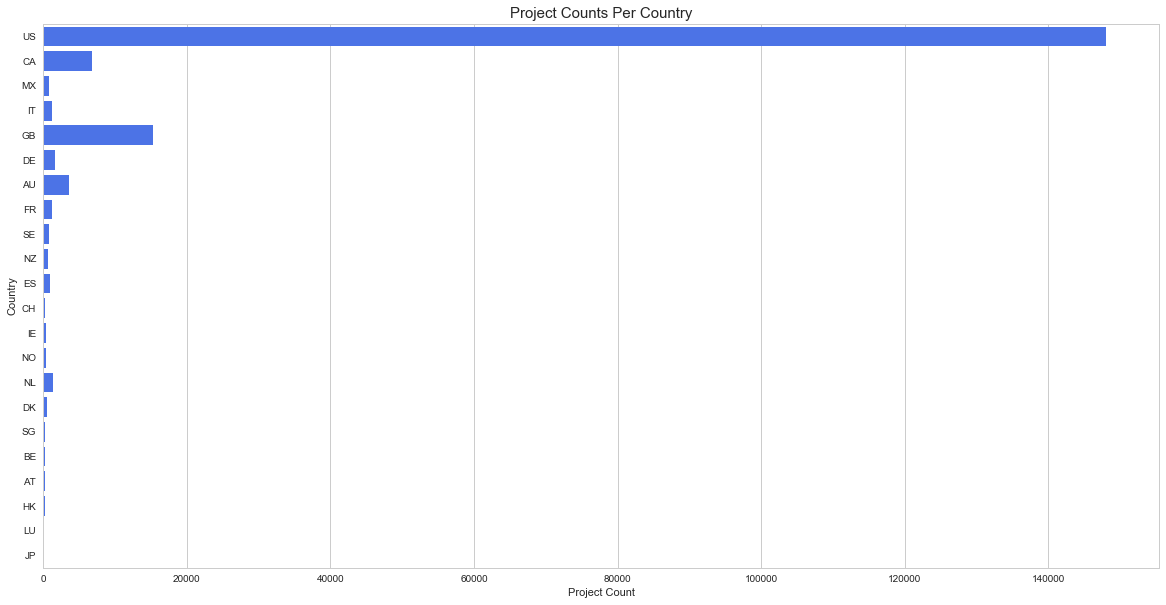

In [133]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
sns.countplot(y="country", data=df, color='#3366ff')
plt.title('Project Counts Per Country', fontsize=15)
plt.ylabel('Country')
plt.xlabel('Project Count')

Text(0,0.5,'Country')

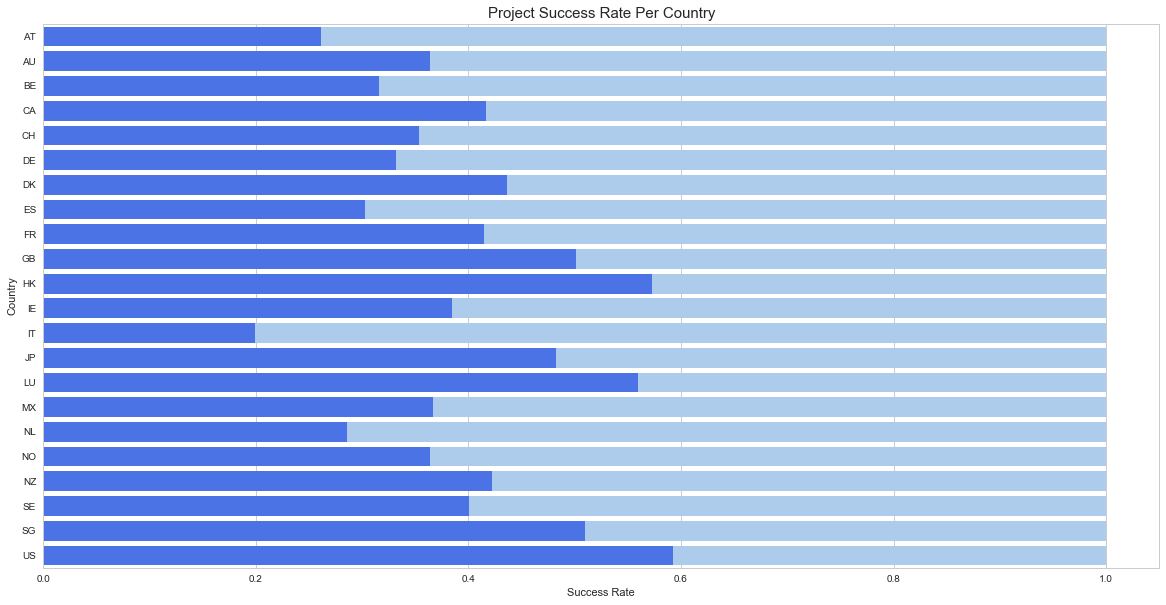

In [134]:
countries=df.groupby(['country', 'state']).count()['goal']
countries=countries[countries.index.get_level_values('state').isin(['successful', 'failed'])]

plt.figure(figsize=(20,10))
sns.barplot(y=countries.index.get_level_values('country').unique(),x=[1 for i in range(1,len(list(countries)),2)],color='#a3ccf5', orient="h")
sns.barplot(y=countries.index.get_level_values('country').unique(),x=[countries[i]/(countries[i-1]+countries[i]) for i in range(1,len(list(countries)),2)],color='#3366ff',orient="h")
plt.title('Project Success Rate Per Country', fontsize=15)
plt.xlabel('Success Rate')
plt.ylabel('Country')

Text(0,0.5,'City')

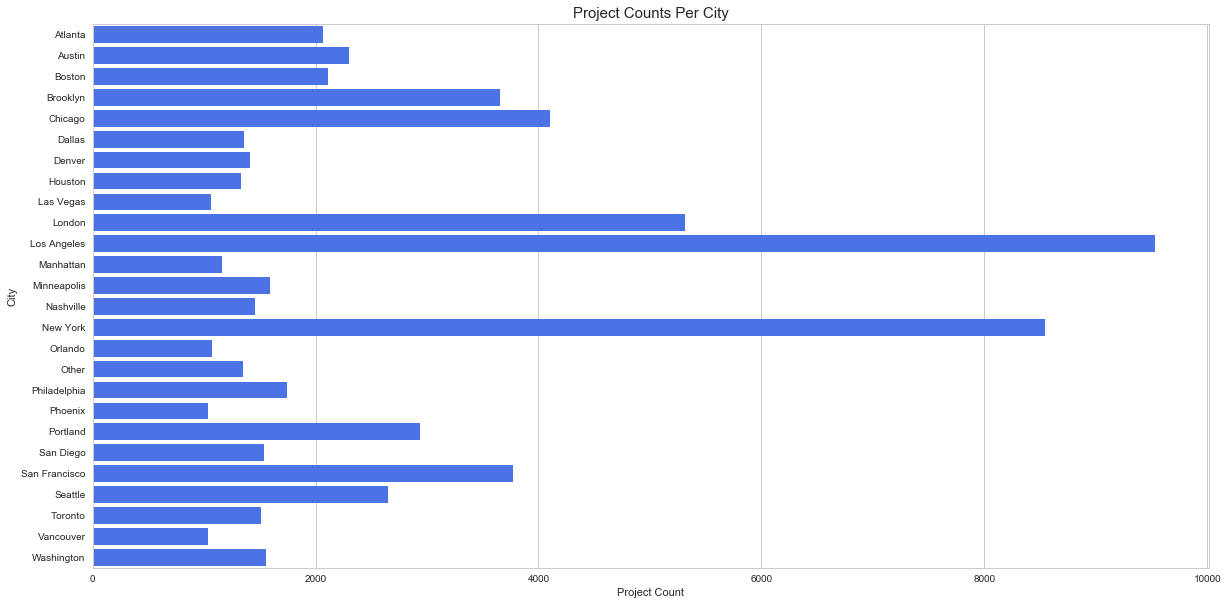

In [135]:
locn=list(df.groupby('location').location.count()[df.groupby('location').location.count()>1000].index)
locc=list(df.groupby('location').location.count()[df.groupby('location').location.count()>1000])

plt.figure(figsize=(20,10))
sns.barplot(y=locn,x=locc,color='#3366ff',orient="h")
plt.title('Project Counts Per City', fontsize=15)
plt.xlabel('Project Count')
plt.ylabel('City')

Text(0,0.5,'City')

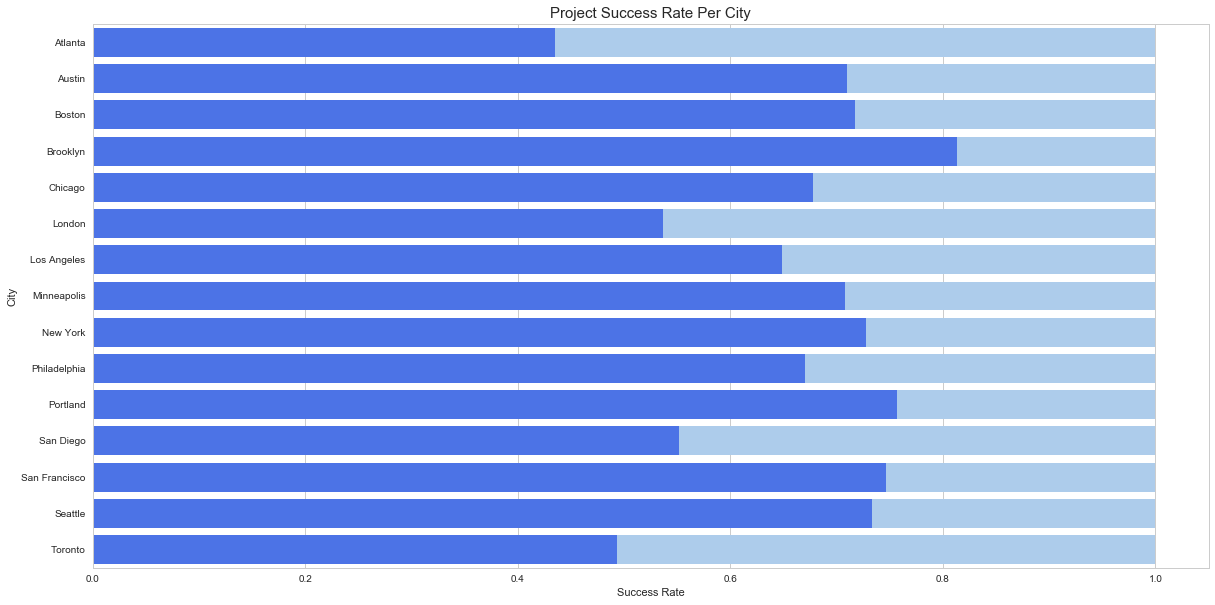

In [136]:
cts=df.groupby(['location', 'state']).count()['goal']
cts=cts[cts.index.get_level_values('state').isin(['successful', 'failed'])]
cts=cts[cts.index.get_level_values('location').isin(['New York', 'London', 'Los Angeles', 'Chicago', 
                                                       'San Francisco','Brooklyn','Portland', 'Seattle', 
                                                       'Austin', 'Boston', 'Atlanta', 'Philadelphia',
                                                       'Minneapolis','San Diego', 'Toronto'])]
plt.figure(figsize=(20,10))
sns.barplot(y=cts.index.get_level_values('location').unique(),x=[1 for i in range(1,len(list(cts)),2)],color='#a3ccf5',orient="h")
sns.barplot(y=cts.index.get_level_values('location').unique(),x=[cts[i]/(cts[i-1]+cts[i]) for i in range(1,len(list(cts)),2)],color='#3366ff',orient="h")
plt.title('Project Success Rate Per City', fontsize=15)
plt.xlabel('Success Rate')
plt.ylabel('City')

Text(0.5,0,'State')

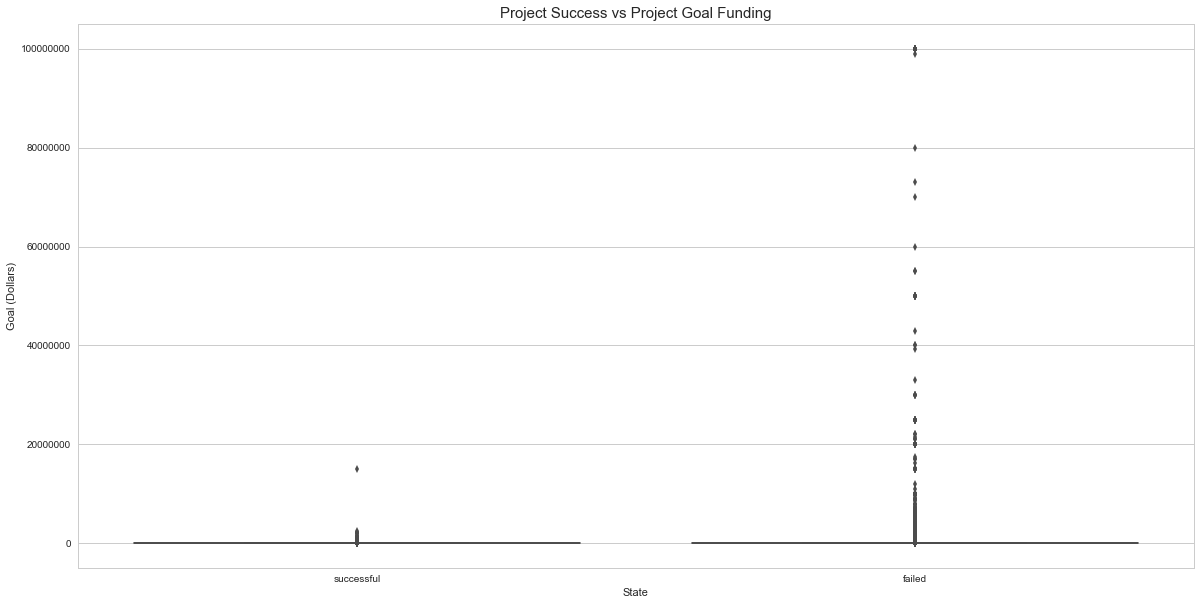

In [137]:
plt.figure(figsize=(20,10))
sns.boxplot(y='goal',x='state', data=df, color='b')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Project Success vs Project Goal Funding', fontsize=15)
plt.ylabel('Goal (Dollars)')
plt.xlabel('State')

Text(0.5,0,'State')

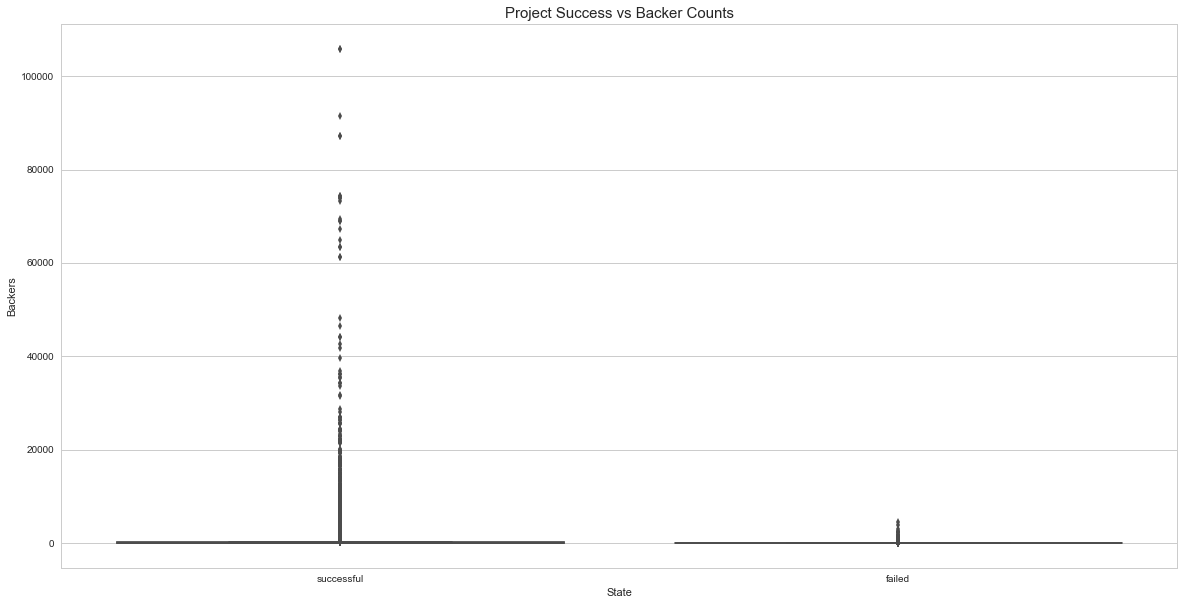

In [138]:
plt.figure(figsize=(20,10))
sns.boxplot(y='backers_count',x='state', data=df, color='b')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Project Success vs Backer Counts', fontsize=15)
plt.ylabel('Backers')
plt.xlabel('State')

Text(0,0.5,'Category')

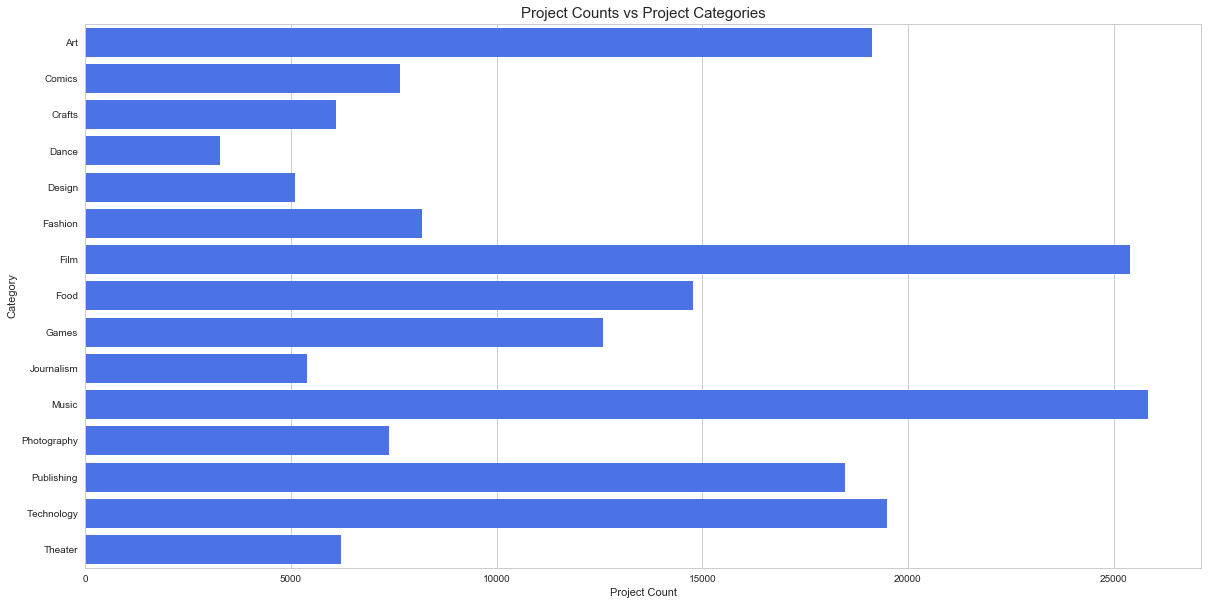

In [139]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
sns.countplot(y="category", data=df, color='#3366ff')
plt.title('Project Counts vs Project Categories', fontsize=15)
plt.xlabel('Project Count')
plt.ylabel('Category')

Text(0,0.5,'Category')

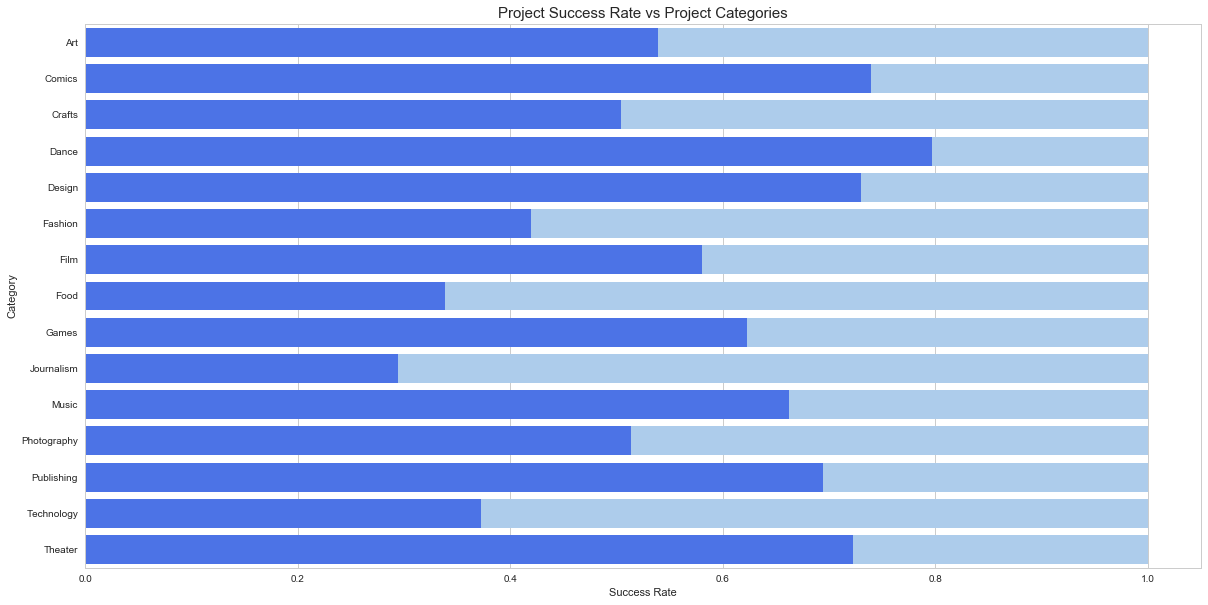

In [140]:
categories=df.groupby(['category', 'state']).count()['goal']
categories=categories[categories.index.get_level_values('state').isin(['successful', 'failed'])]

plt.figure(figsize=(20,10))
sns.barplot(y=categories.index.get_level_values('category').unique(),x=[1 for i in range(1,len(list(categories)),2)],color='#a3ccf5', orient="h")
sns.barplot(y=categories.index.get_level_values('category').unique(),x=[categories[i]/(categories[i-1]+categories[i]) for i in range(1,len(list(categories)),2)],color='#3366ff',orient="h")
plt.title('Project Success Rate vs Project Categories', fontsize=15)
plt.xlabel('Success Rate')
plt.ylabel('Category')

Text(0,0.5,'Pledged (Dollars)')

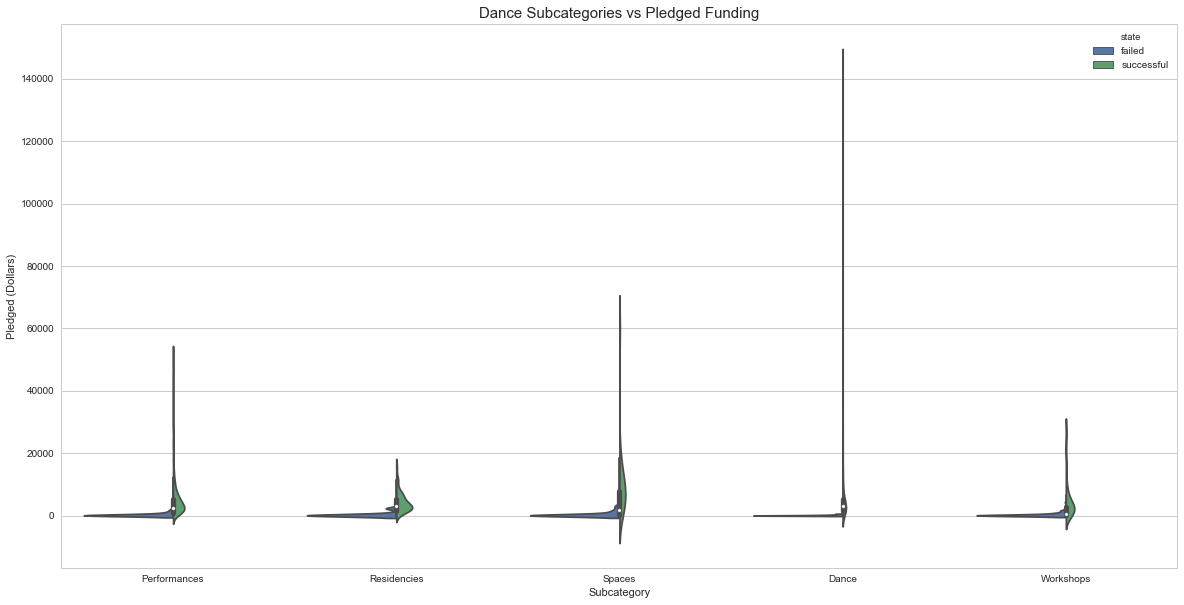

In [141]:
dance = df[df.category=='Dance']

plt.figure(figsize=(20,10))
sns.violinplot(x="subcategory", y="usd_pledged", hue="state", data=dance, split=True)
plt.title('Dance Subcategories vs Pledged Funding', fontsize=15)
plt.xlabel('Subcategory')
plt.ylabel('Pledged (Dollars)')

Text(0,0.5,'Pledged (Dollars)')

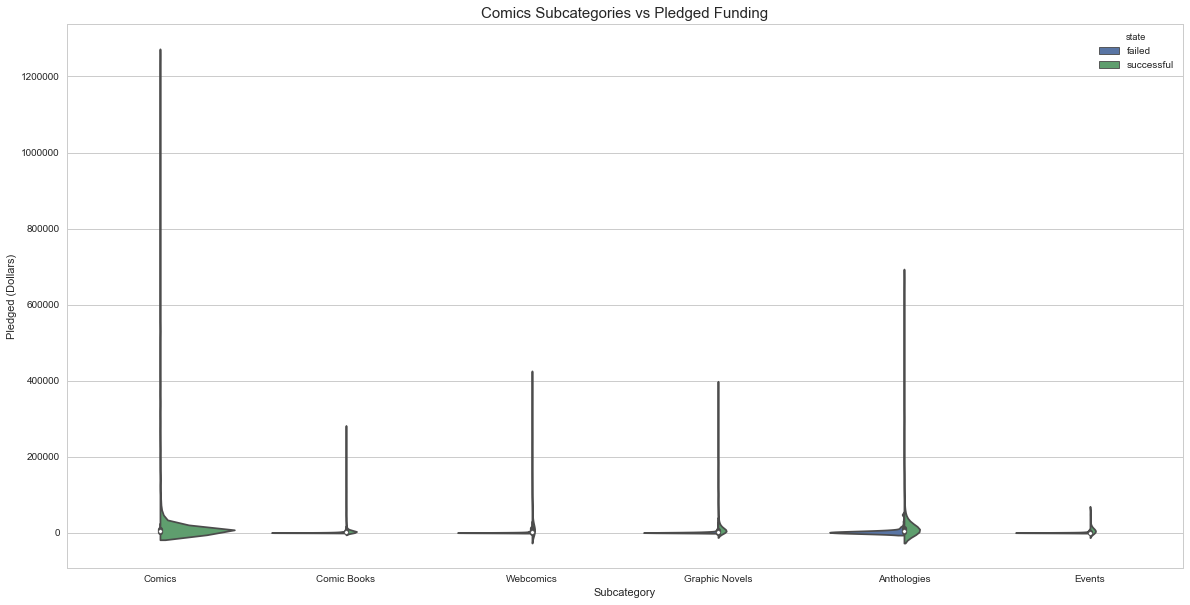

In [142]:
comics = df[df.category=='Comics']

plt.figure(figsize=(20,10))
sns.violinplot(x="subcategory", y="usd_pledged", hue="state", data=comics, split=True, hue_order=['failed','successful'])
plt.title('Comics Subcategories vs Pledged Funding', fontsize=15)
plt.xlabel('Subcategory')
plt.ylabel('Pledged (Dollars)')

Text(0.5,0,'Success Rate')

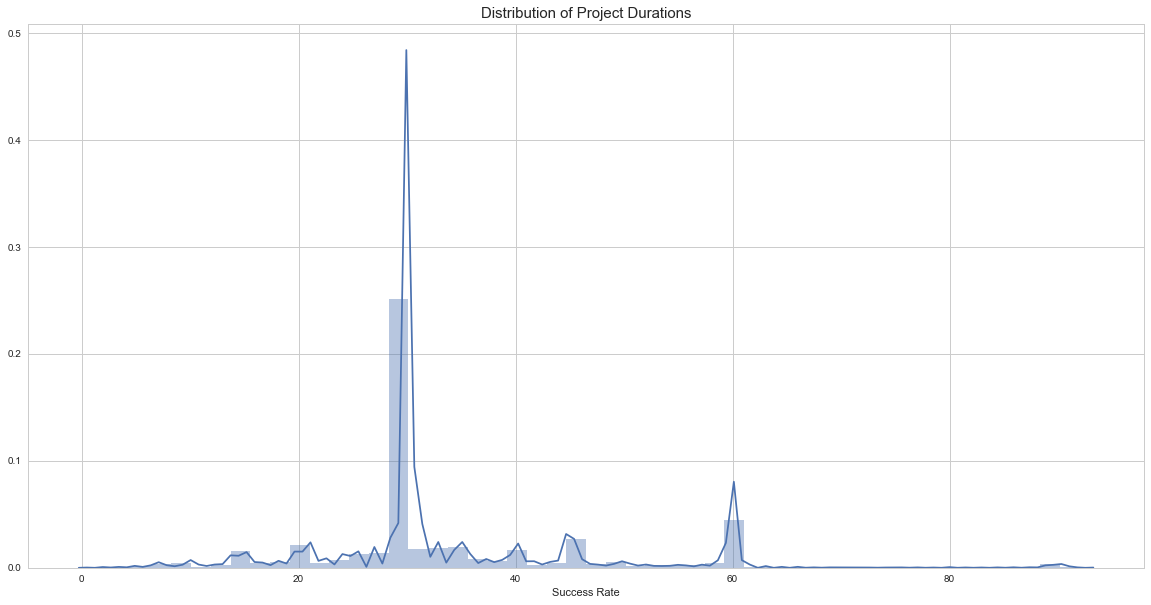

In [143]:
plt.figure(figsize=(20,10))
sns.distplot(df.duration)
plt.title('Distribution of Project Durations', fontsize=15)
plt.xlabel('Success Rate')

Text(0.5,0,'Project Duration (Days)')

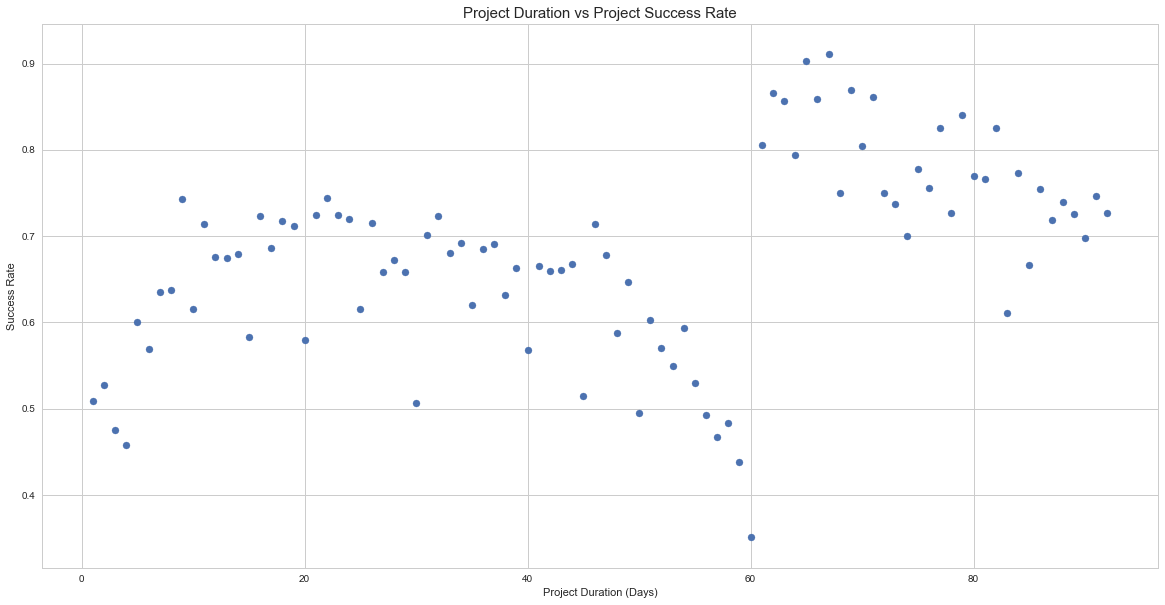

In [144]:
durations=df.groupby(['duration', 'state']).count()['goal']
durations=durations[durations.index.get_level_values('state').isin(['successful', 'failed'])]

plt.figure(figsize=(20,10))
plt.scatter(durations.index.get_level_values('duration').unique(),[list(durations)[i]/(list(durations)[i-1]+list(durations)[i]) for i in range(1,len(list(durations)),2)])
plt.title('Project Duration vs Project Success Rate', fontsize=15)
plt.ylabel('Success Rate')
plt.xlabel('Project Duration (Days)')

Text(0.5,0,'Success Rate')

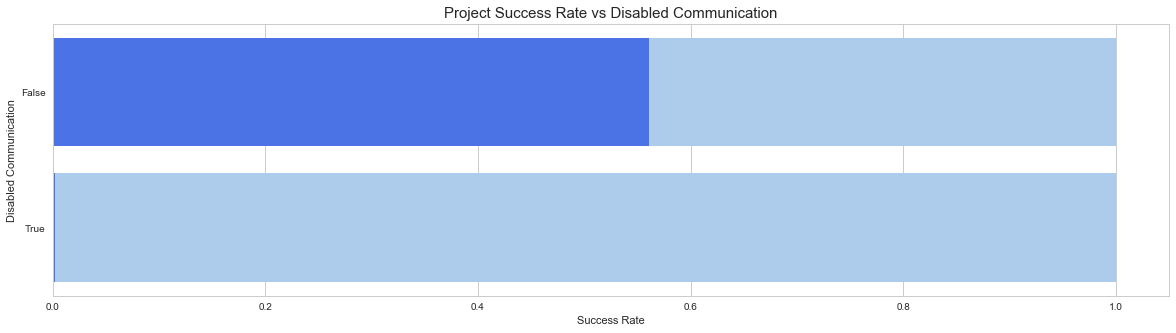

In [145]:
coms=df.groupby(['disable_communication', 'state']).count()['goal']

plt.figure(figsize=(20,5))
sns.barplot(y=coms.index.get_level_values('disable_communication').unique(),x=[1,1],color='#a3ccf5', orient="h")
sns.barplot(y=coms.index.get_level_values('disable_communication').unique(),
            x=[(coms[0][1]/(coms[0][0]+coms[0][1])), 1/coms[1]],color='#3366ff',orient="h")
plt.title('Project Success Rate vs Disabled Communication', fontsize=15)
plt.ylabel('Disabled Communication')
plt.xlabel('Success Rate')

Text(0.5,0,'Success Rate')

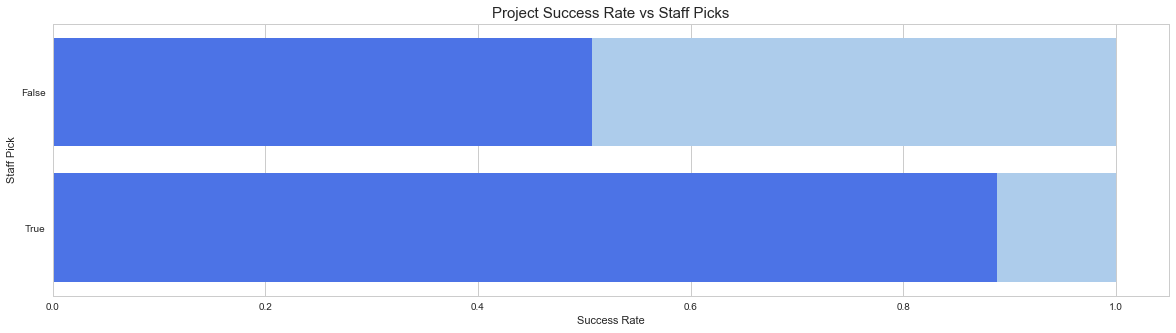

In [146]:
staff=df.groupby(['staff_pick', 'state']).count()['goal']

plt.figure(figsize=(20,5))
sns.barplot(y=staff.index.get_level_values('staff_pick').unique(),x=[1,1],color='#a3ccf5', orient="h")
sns.barplot(y=staff.index.get_level_values('staff_pick').unique(),x=[(staff[0][1]/(staff[0][0]+staff[0][1])), staff[1][1]/(staff[1][0]+staff[1][1])],color='#3366ff',orient="h")
plt.title('Project Success Rate vs Staff Picks', fontsize=15)
plt.ylabel('Staff Pick')
plt.xlabel('Success Rate')

<a id='section_4'></a>

## 4. Preprocessing

In [147]:
state={'state': {'failed': 0,'successful': 1, 'live': 2 }}
df.replace(state, inplace=True)

df['category']=df['category'].astype('category')
df['category']=df['category'].cat.codes

df['subcategory']=df['subcategory'].astype('category')
df['subcategory']=df['subcategory'].cat.codes

df['location']=df['location'].astype('category')
df['location']=df['location'].cat.codes

df['country']=df['country'].astype('category')
df['country']=df['country'].cat.codes

df.disable_communication=df.disable_communication.astype(int)
df.staff_pick=df.staff_pick.astype(int)

In [148]:
df.head()

,backers_count,category,country,disable_communication,goal,staff_pick,state,usd_pledged,location,subcategory,duration
0,80,0,21,0,2800.00,0,1,3596.00,7747,85,22
1,47,0,21,0,3900.00,0,1,4117.00,515,10,23
2,80,0,21,0,750.00,0,1,3125.00,5885,94,19
3,82,0,21,0,4500.00,0,1,4586.00,10966,112,40
4,31,0,21,0,1000.00,0,1,1036.00,8167,94,5


Text(0.5,1,'Correlation of Features')

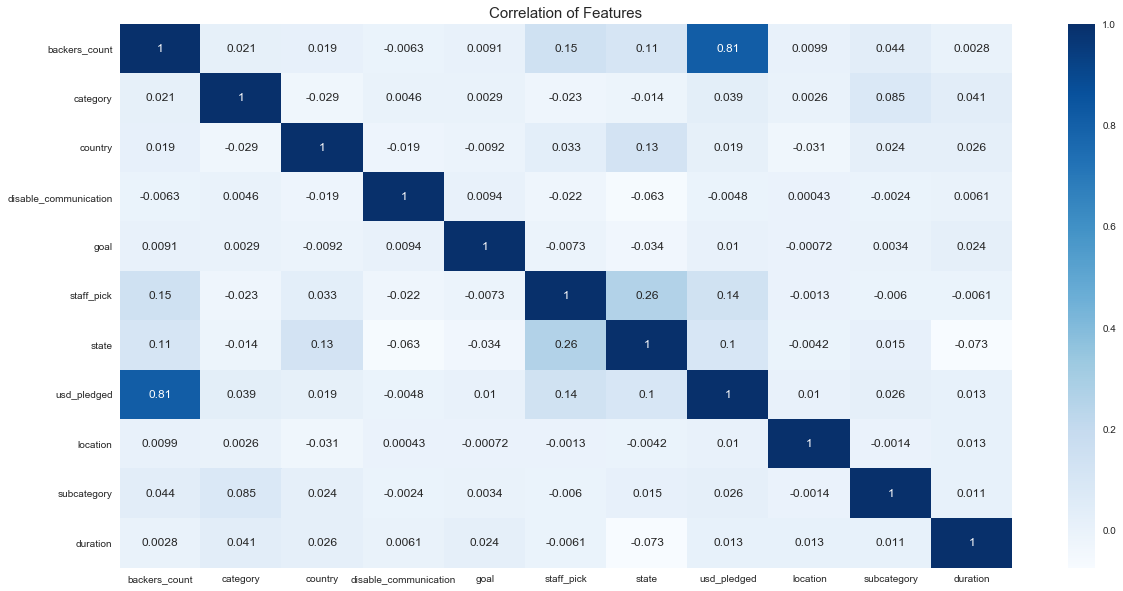

In [149]:
plt.figure(figsize=(20,10))
sns.heatmap(data=df.corr(),annot=True,cmap="Blues")
plt.title('Correlation of Features', fontsize=15)

In [150]:
X=df[['backers_count', 'category', 'country', 'disable_communication', 'goal', 'staff_pick',
        'usd_pledged', 'location','subcategory', 'duration']]
y=df['state']

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print("X_train Shape: {}".format(X_train.shape))
print("X_test Shape: {}".format(X_test.shape))
print("Y_train Shape: {}".format(y_train.shape))
print("Y_test Shape: {}".format(y_test.shape))

X_train Shape: (138746, 10)
X_test Shape: (46249, 10)
Y_train Shape: (138746,)
Y_test Shape: (46249,)


<a id='section_5'></a>

## 5. Modeling

In [152]:
y_test.mean()

0.5588012713788406

In [153]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logpred = logreg.predict(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knnpred = knn.predict(X_test)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_test)

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbcpred = gbc.predict(X_test)

In [154]:
pd.DataFrame(data=[accuracy_score(y_test, logpred),accuracy_score(y_test, knnpred),accuracy_score(y_test, rfcpred),accuracy_score(y_test, gbcpred)],
             index=['Logistic Regression','KNeighbors Classifier','Random Forest Classifier','Gradient Boosting Classifier', ], columns=['accuracy']).sort_values(by = ['accuracy'], ascending = False)

,accuracy
Random Forest Classifier,0.99
KNeighbors Classifier,0.99
Gradient Boosting Classifier,0.98
Logistic Regression,0.94


In [155]:
print(confusion_matrix(y_test, rfcpred))

[[20131   274]
 [  186 25658]]


In [156]:
grid=dict(max_depth=list(range(15,21)), n_estimators=list(range(5,10)))
search=GridSearchCV(rfc, grid,scoring='accuracy')
search.fit(X_train,y_train)
search.grid_scores_

C:\Users\olegh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.98549, std: 0.00164, params: {'max_depth': 15, 'n_estimators': 5},
 mean: 0.98827, std: 0.00024, params: {'max_depth': 15, 'n_estimators': 6},
 mean: 0.98773, std: 0.00056, params: {'max_depth': 15, 'n_estimators': 7},
 mean: 0.98856, std: 0.00131, params: {'max_depth': 15, 'n_estimators': 8},
 mean: 0.98827, std: 0.00025, params: {'max_depth': 15, 'n_estimators': 9},
 mean: 0.98724, std: 0.00081, params: {'max_depth': 16, 'n_estimators': 5},
 mean: 0.98776, std: 0.00056, params: {'max_depth': 16, 'n_estimators': 6},
 mean: 0.98765, std: 0.00064, params: {'max_depth': 16, 'n_estimators': 7},
 mean: 0.98904, std: 0.00045, params: {'max_depth': 16, 'n_estimators': 8},
 mean: 0.98878, std: 0.00071, params: {'max_depth': 16, 'n_estimators': 9},
 mean: 0.98791, std: 0.00051, params: {'max_depth': 17, 'n_estimators': 5},
 mean: 0.98818, std: 0.00057, params: {'max_depth': 17, 'n_estimators': 6},
 mean: 0.98912, std: 0.00018, params: {'max_depth': 17, 'n_estimators': 7},
 mean: 0.989

In [157]:
rfc = RandomForestClassifier(max_depth=16, n_estimators=8, max_features=6, n_jobs=-1, random_state=1)
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_test)
accuracy_score(y_test, rfcpred)

0.9925836234296957

In [158]:
print(confusion_matrix(y_test, rfcpred))

[[20200   205]
 [  138 25706]]
